
## 写在前面：

本程序以VGG16为例，用Mindspore框架进行VGG的数据集处理、网络搭建以及训练和测试。

VGGNet是牛津大学视觉几何组(Visual Geometry Group)提出的模型，该模型在2014ImageNet图像分类与定位挑战赛 ILSVRC-2014中取得在分类任务第二，定位任务第一的优异成绩。VGGNet突出的贡献是证明了很小的卷积，通过增加网络深度可以有效提高性能。VGG很好的继承了Alexnet的衣钵同时拥有着鲜明的特点。即网络层次较深。 VGGNet模型有A-E五种结构网络，深度分别为11,11,13,16,19。其中较为典型的网络结构主要有VGG16和VGG19。

##### 本程序使用的模型为VGG16,使用的数据集为CIFAR-10数据集。

###### 参考博客：https://blog.csdn.net/hgnuxc_1993/article/details/115956774

###### 参考博客：https://blog.csdn.net/weixin_43496706/article/details/10121098

###### 参考博客：https://zhuanlan.zhihu.com/p/9100284

# VGG图像分类

图像分类是最基础的计算机视觉应用，属于有监督学习类别，如给定一张图像(猫、狗、飞机、汽车等等)，判断图像所属的类别。本章将介绍使用VGG16网络对CIFAR-10数据集进行分类。

## VGG网络介绍

VGGNet是牛津大学视觉几何组(Visual Geometry Group)提出的模型，该模型在2014ImageNet图像分类与定位挑战赛 ILSVRC-2014中取得在分类任务第二，定位任务第一的优异成绩。VGGNet突出的贡献是证明了很小的卷积，通过增加网络深度可以有效提高性能。VGG很好的继承了Alexnet的衣钵同时拥有着鲜明的特点。即网络层次较深。 VGGNet模型有A-E五种结构网络，深度分别为11,11,13,16,19。其中较为典型的网络结构主要有VGG16和VGG19。

VGG是Oxford的Visual Geometry Group的组提出的（大家应该能看出VGG名字的由来了）。该网络是在ILSVRC 2014上的相关工作，主要工作是证明了增加网络的深度能够在一定程度上影响网络最终的性能。VGG有两种结构，分别是VGG16和VGG19，两者并没有本质上的区别，只是网络深度不一样。

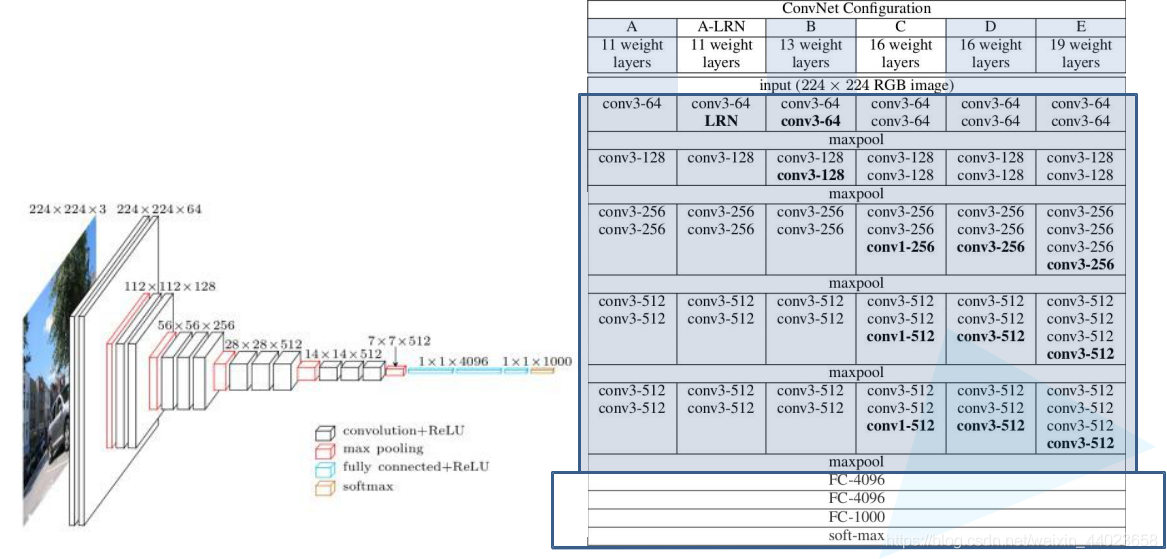

VGG16相比AlexNet的一个改进是采用连续的几个3x3的卷积核代替AlexNet中的较大卷积核（11x11，7x7，5x5）。对于给定的感受野（与输出有关的输入图片的局部大小），采用堆积的小卷积核是优于采用大的卷积核，因为多层非线性层可以增加网络深度来保证学习更复杂的模式，而且代价还比较小（参数更少）。
简单来说，在VGG中，使用了3个3x3卷积核来代替7x7卷积核，使用了2个3x3卷积核来代替5*5卷积核，这样做的主要目的是在保证具有相同感知野的条件下，提升了网络的深度，在一定程度上提升了神经网络的效果。



> 了解VGG网络更多详细内容，参见[VGG论文](https://arxiv.org/abs/1409.1556)。

### 这里使用了 ***download.download函数*** 来下载 ***CIFAR-10*** 数据集

### *`需要预先在控制台”pip install download“`*

CIFAR-10数据集由60000张32x32彩色图片组成，总共有10个类别，每类6000张图片。有50000个训练样本和10000个测试样本。10个类别包含飞机、汽车、鸟类、猫、鹿、狗、青蛙、马、船和卡车。
整个数据集被分为5个训练批次和1个测试批次，每一批10000张图片。测试批次包含10000张图片，是由每一类图片随机抽取出1000张组成的集合。剩下的50000张图片每一类的图片数量都是5000张，训练批次是由剩下的50000张图片打乱顺序，然后随机分成5份，所以可能某个训练批次中10个种类的图片数量不是对等的，会出现一个类的图片数量比另一类多的情况。

##### 会在同目录下创建一个名为datasets-cifar10-bin文件夹，然后自动将数据集下载至文件夹中。下载好之后结构如下：

```Text
datasets-cifar10-bin/cifar-10-batches-bin
├── batches.meta.text
├── data_batch_1.bin
├── data_batch_2.bin
├── data_batch_3.bin
├── data_batch_4.bin
├── data_batch_5.bin
├── readme.html
└── test_batch.bin

```

In [3]:
from download import download
url = "http://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz"
download(url, "./datasets-cifar10-bin", kind="tar.gz")

Creating data folder...

file_sizes: 100%|████████████████████████████| 170M/170M [00:34<00:00, 4.93MB/s]
Extracting tar.gz file...
Successfully downloaded / unzipped to ./datasets-cifar10-bin


'./datasets-cifar10-bin'

### 下面的部分是训练和测试数据集的构建

In [11]:
import mindspore as ms
import numpy as np
import mindspore.dataset as ds
import mindspore.dataset.vision as vision
from mindspore import nn, ops

data_dir = "./datasets-cifar10-bin/cifar-10-batches-bin" # 数据集根目录
batch_size = 6 # 批量大小
image_size = 32 # 训练图像空间大小
workers = 4 # 并行线程个数
num_classes = 10 # 分类数量

batch_size,image_size,workers,num_classes

(6, 32, 4, 10)

### 利用mindspore.dataset中的函数Cifar10Dataset对CIFAR-10数据集进行处理。
该函数读取和解析CIFAR-10数据集的源文件构建数据集。
生成的数据集有两列: [image, label] 。 image 列的数据类型是uint8。label 列的数据类型是uint32。
具体说明查看API文档：https://www.mindspore.cn/docs/zh-CN/master/api_python/dataset/mindspore.dataset.Cifar10Dataset.html?highlight=cifar10dataset

+ `dataset_dir`：数据集根目录
+ `usage`：值可以为"train"或"test"，表示是构建训练集还是测试集
+ `resize`：处理后的数据集图像大小，本程序中设置为32
+ `batch_size`：批量大小
+ `workers`：并行线程个数
+ `return`：返回处理好的数据集
+ `shuffle`：shuffle=True表示需要混洗数据集，即随机在其中取数据而不是按照顺序

In [5]:
def create_dataset_cifar10(dataset_dir, usage, resize, batch_size, workers):
    data_set = ds.Cifar10Dataset(dataset_dir=dataset_dir,
                                 usage=usage,
                                 num_parallel_workers=workers,
                                 shuffle=True)

    trans = []#需要做的变化的集合
    """
    对于训练集，首先进行随机裁剪和随机翻转的操作。
    使用mindspore.dataset.vision.RandomCrop对输入图像进行随机区域的裁剪,大小为(32, 32)。(4, 4, 4, 4)表示在裁剪前，将在图像上下左右各填充4个像素的空白。
    使用mindspore.dataset.RandomHorizontalFlip,对输入图像按50%的概率进行水平随机翻转
    """
    if usage == "train":
        trans += [
            vision.RandomCrop((32, 32), (4, 4, 4, 4)),
            vision.RandomHorizontalFlip(prob=0.5)
        ]

    """
    对数据集进行大小、规模的重组，以及归一化（帮助模型收敛）
    """
    trans += [
        vision.Resize(resize),
        vision.Rescale(1.0 / 255.0, 0.0),
        vision.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]),
        vision.HWC2CHW()
    ]

    #对于label进行的操作
    target_trans = [(lambda x: np.array([x]).astype(np.int32)[0])]

    # 数据映射操作
    data_set = data_set.map(
        operations=trans,
        input_columns='image',
        num_parallel_workers=workers)

    data_set = data_set.map(
        operations=target_trans,
        input_columns='label',
        num_parallel_workers=workers)

    # 批量操作
    data_set = data_set.batch(batch_size)


    return data_set


In [10]:
# 利用上面写好的那个函数，获取处理后的训练与测试数据集
dataset_train = create_dataset_cifar10(dataset_dir=data_dir,
                                       usage="train",
                                       resize=image_size,
                                       batch_size=batch_size,
                                       workers=workers)
step_size_train = dataset_train.get_dataset_size()
index_label_dict = dataset_train.get_class_indexing()

dataset_val = create_dataset_cifar10(dataset_dir=data_dir,
                                     usage="test",
                                     resize=image_size,
                                     batch_size=batch_size,
                                     workers=workers)
step_size_val = dataset_val.get_dataset_size()

step_size_val,step_size_train,index_label_dict,dataset_train

(1667,
 8334,
 {},
 <mindspore.dataset.engine.datasets.BatchDataset at 0x22742999ac0>)

### 对训练数据集进行可视化操作

In [12]:
import matplotlib.pyplot as plt
import numpy as np

data_iter = next(dataset_train.create_dict_iterator())

images = data_iter["image"].asnumpy()
labels = data_iter["label"].asnumpy()
print(f"Image shape: {images.shape}, Label: {labels}")

classes = []

with open(data_dir+"/batches.meta.txt", "r") as f:
    for line in f:
        line = line.rstrip()
        if line != '':
            classes.append(line)

plt.figure()
for i in range(6):
    plt.subplot(2, 3, i+1)
    image_trans = np.transpose(images[i], (1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    image_trans = std * image_trans + mean
    image_trans = np.clip(image_trans, 0, 1)
    plt.title(f"{classes[labels[i]]}")
    plt.imshow(image_trans)
    plt.axis("off")
#展示训练集的数据（标签与原图）
plt.show()


Image shape: (6, 3, 32, 32), Label: [9 6 6 9 5 1]


## 构建VGG16网络

#### 关于VGG16网络结构的介绍：
如图：
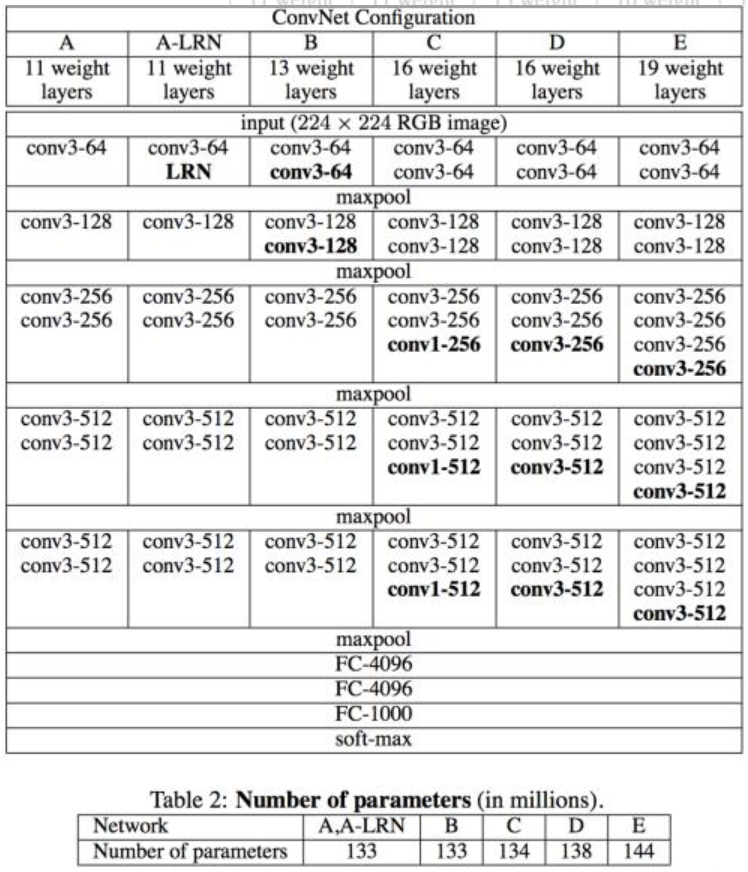

1、输入224x224x3的图片，经64个3x3的卷积核作两次卷积+ReLU，卷积后的尺寸变为224x224x64

2、作max pooling（最大化池化），池化单元尺寸为2x2（效果为图像尺寸减半），池化后的尺寸变为112x112x64

3、经128个3x3的卷积核作两次卷积+ReLU，尺寸变为112x112x128

4、作2x2的max pooling池化，尺寸变为56x56x128

5、经256个3x3的卷积核作三次卷积+ReLU，尺寸变为56x56x256

6、作2x2的max pooling池化，尺寸变为28x28x256

7、经512个3x3的卷积核作三次卷积+ReLU，尺寸变为28x28x512

8、作2x2的max pooling池化，尺寸变为14x14x512

9、经512个3x3的卷积核作三次卷积+ReLU，尺寸变为14x14x512

10、作2x2的max pooling池化，尺寸变为7x7x512

11、与两层1x1x4096，一层1x1x1000进行全连接+ReLU（共三层）

12、通过softmax输出1000个预测结果(最终会取可能性最大的那个预测结果作为最终预测输出)

###### ATTENTION：由于本程序中使用的数据集中，每张图片的大小为32*32，因此根据这个大小对VGG网络的输入尺寸进行了微调，实际应用中，针对不同的大小，对最后一块的nn.Dense的参数进行调整即可。


#### VGG16网络的模型图如下
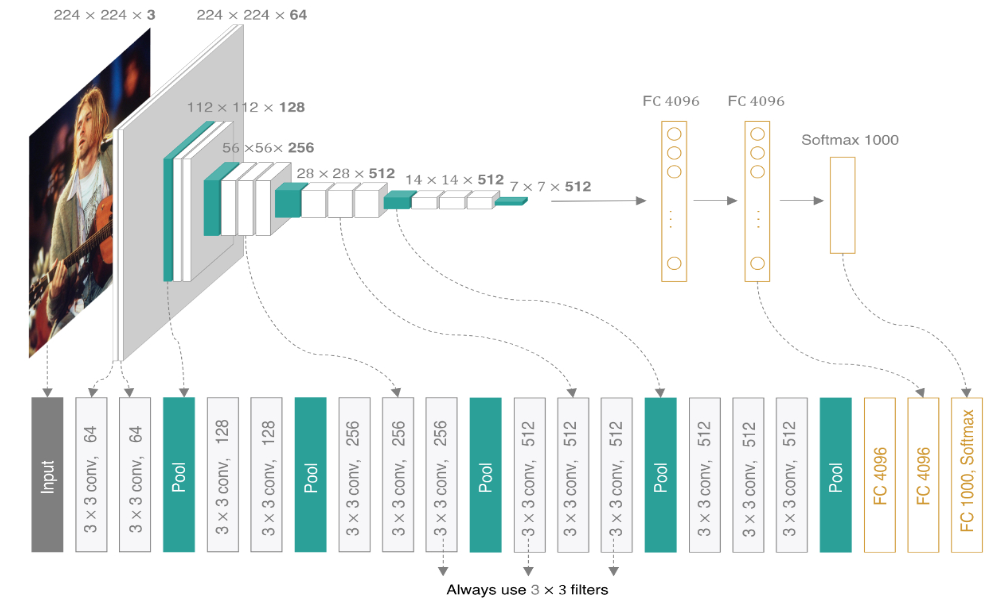

### 测试细节
论文在测试时，将全连接层转换为卷积层。第一个全连接层转换为7x7的卷积层，最后两个全连接层转换为1x1的卷积层。示意图如下：
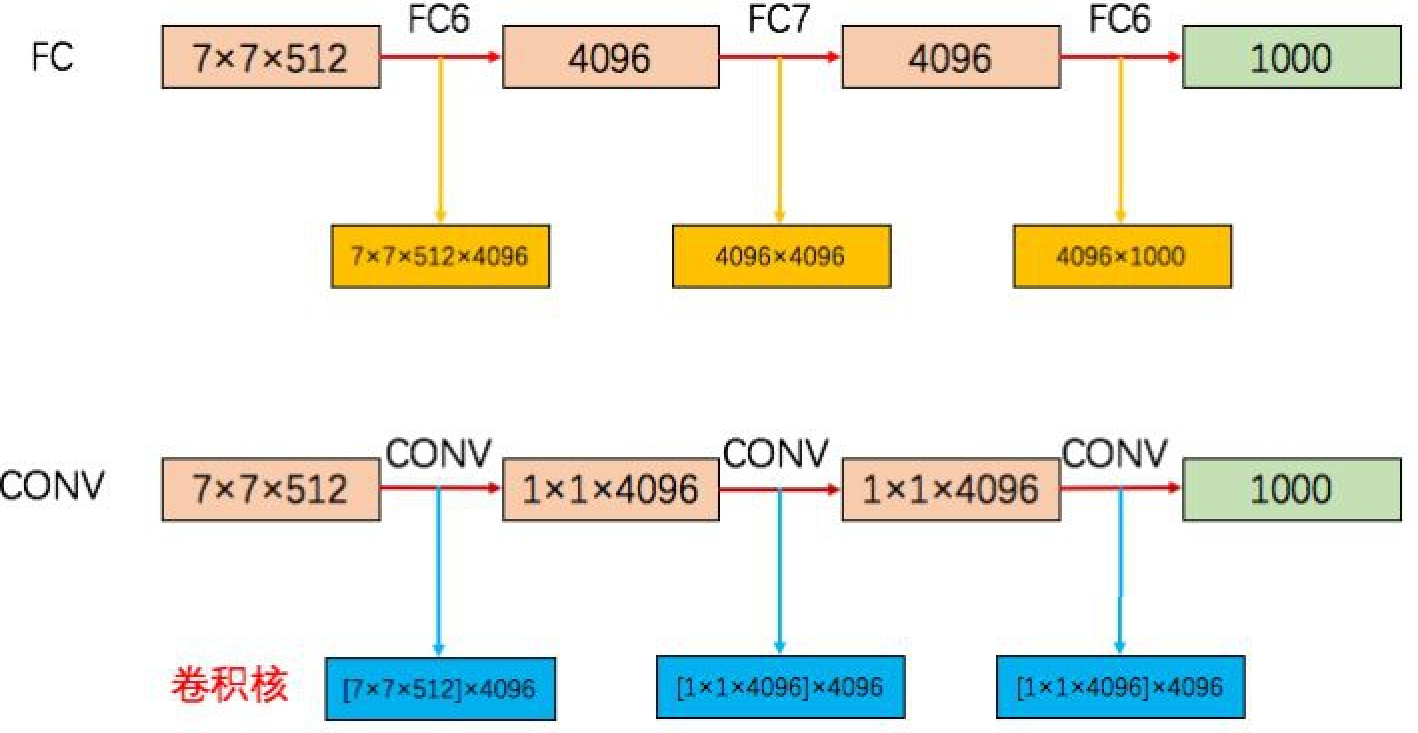
只是把权重的维度变换和拓展了。经过转换的网络就没有了全连接层，这样网络就可以接受任意尺寸的输入，而不是像之前之能输入固定大小的输入。

这样网络的输出是一个class score map，map的每个通道表示每个分类，map的分辨率是可变的，取决于输入图片的大小。为了获得输出的向量，需要对class score map进行spatially averaged。

In [ ]:
class VGG16(nn.Cell):
    def __init__(self):
        super().__init__()
        numClasses = 10
        self.all_sequential = nn.SequentialCell(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, pad_mode="pad"),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, pad_mode="pad"),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1, pad_mode="pad"),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, pad_mode="pad"),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1, pad_mode="pad"),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, pad_mode="pad"),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, pad_mode="pad"),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1, pad_mode="pad"),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, pad_mode="pad"),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, pad_mode="pad"),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1, pad_mode="pad"),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, pad_mode="pad"),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, pad_mode="pad"),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # 原始模型vgg16输入image大小是224*224，这里使用的数据集输入大小为32*32，缩小7倍
            # 可以根据需要的大小来调整，比如如果输入的image大小是224*224，那么由于224/32=7，因此就把第一个nn.Dense的参数改成512*7*7，其他不变
            nn.Flatten(),
            nn.Dense(512*1*1, 256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Dense(256, 256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Dense(256, numClasses),
        )

    def construct(self, x):
        x = self.all_sequential(x)
        return x


###### 这个函数主要是用来处理预训练模型的，就是如果有预训练模型参数需要在训练之前输入，就把pretrained设为True，此处由于没有预训练模型提供，因此后面在训练的时候设置的是False。
###### 如果不需要预训练的话其实这个函数就是”model = VGG16()“然后return了model而已。

In [14]:

from mindspore import load_checkpoint, load_param_into_net
def _vgg16(pretrained: bool = False):
    model = VGG16()
    "VGG16模型"
    #预训练模型的下载网址
    model_url = "https://download.mindspore.cn/model_zoo/official/cv/vgg/vgg16_ascend_0.5.0_cifar10_official_classification_20200715/vgg16.ckpt"
    #存储路径
    model_ckpt = "./LoadPretrainedModel/vgg16_0715.ckpt"

    if pretrained:
        download(url=model_url, path=model_ckpt)
        param_dict = load_checkpoint(model_ckpt)
        load_param_into_net(model, param_dict)

    return model


## 训练过程和评估过程

Start Training Loop ...
Epoch: [  1/ 10], Steps: [  1/8334], Train Loss: [2.297]
Epoch: [  1/ 10], Steps: [101/8334], Train Loss: [2.289]
Epoch: [  1/ 10], Steps: [201/8334], Train Loss: [2.210]
Epoch: [  1/ 10], Steps: [301/8334], Train Loss: [2.366]
Epoch: [  1/ 10], Steps: [401/8334], Train Loss: [2.056]
Epoch: [  1/ 10], Steps: [501/8334], Train Loss: [2.015]
Epoch: [  1/ 10], Steps: [601/8334], Train Loss: [1.973]
Epoch: [  1/ 10], Steps: [701/8334], Train Loss: [2.180]
Epoch: [  1/ 10], Steps: [801/8334], Train Loss: [1.996]
Epoch: [  1/ 10], Steps: [901/8334], Train Loss: [2.086]
Epoch: [  1/ 10], Steps: [1001/8334], Train Loss: [1.965]
Epoch: [  1/ 10], Steps: [1101/8334], Train Loss: [2.122]
Epoch: [  1/ 10], Steps: [1201/8334], Train Loss: [2.412]
Epoch: [  1/ 10], Steps: [1301/8334], Train Loss: [1.995]
Epoch: [  1/ 10], Steps: [1401/8334], Train Loss: [1.995]
Epoch: [  1/ 10], Steps: [1501/8334], Train Loss: [2.139]
Epoch: [  1/ 10], Steps: [1601/8334], Train Loss: [2.314]


Epoch: [  2/ 10], Steps: [5401/8334], Train Loss: [1.794]
Epoch: [  2/ 10], Steps: [5501/8334], Train Loss: [1.599]
Epoch: [  2/ 10], Steps: [5601/8334], Train Loss: [1.676]
Epoch: [  2/ 10], Steps: [5701/8334], Train Loss: [1.659]
Epoch: [  2/ 10], Steps: [5801/8334], Train Loss: [1.652]
Epoch: [  2/ 10], Steps: [5901/8334], Train Loss: [2.062]
Epoch: [  2/ 10], Steps: [6001/8334], Train Loss: [1.964]
Epoch: [  2/ 10], Steps: [6101/8334], Train Loss: [2.112]
Epoch: [  2/ 10], Steps: [6201/8334], Train Loss: [2.318]
Epoch: [  2/ 10], Steps: [6301/8334], Train Loss: [1.670]
Epoch: [  2/ 10], Steps: [6401/8334], Train Loss: [1.780]
Epoch: [  2/ 10], Steps: [6501/8334], Train Loss: [1.956]
Epoch: [  2/ 10], Steps: [6601/8334], Train Loss: [2.005]
Epoch: [  2/ 10], Steps: [6701/8334], Train Loss: [1.701]
Epoch: [  2/ 10], Steps: [6801/8334], Train Loss: [1.693]
Epoch: [  2/ 10], Steps: [6901/8334], Train Loss: [1.986]
Epoch: [  2/ 10], Steps: [7001/8334], Train Loss: [1.763]
Epoch: [  2/ 1

Epoch: [  4/ 10], Steps: [2001/8334], Train Loss: [1.880]
Epoch: [  4/ 10], Steps: [2101/8334], Train Loss: [1.848]
Epoch: [  4/ 10], Steps: [2201/8334], Train Loss: [2.182]
Epoch: [  4/ 10], Steps: [2301/8334], Train Loss: [1.757]
Epoch: [  4/ 10], Steps: [2401/8334], Train Loss: [1.722]
Epoch: [  4/ 10], Steps: [2501/8334], Train Loss: [1.923]
Epoch: [  4/ 10], Steps: [2601/8334], Train Loss: [2.526]
Epoch: [  4/ 10], Steps: [2701/8334], Train Loss: [1.738]
Epoch: [  4/ 10], Steps: [2801/8334], Train Loss: [1.977]
Epoch: [  4/ 10], Steps: [2901/8334], Train Loss: [1.782]
Epoch: [  4/ 10], Steps: [3001/8334], Train Loss: [1.691]
Epoch: [  4/ 10], Steps: [3101/8334], Train Loss: [1.785]
Epoch: [  4/ 10], Steps: [3201/8334], Train Loss: [1.865]
Epoch: [  4/ 10], Steps: [3301/8334], Train Loss: [1.701]
Epoch: [  4/ 10], Steps: [3401/8334], Train Loss: [1.969]
Epoch: [  4/ 10], Steps: [3501/8334], Train Loss: [1.700]
Epoch: [  4/ 10], Steps: [3601/8334], Train Loss: [1.829]
Epoch: [  4/ 1

Epoch: [  5/ 10], Steps: [7401/8334], Train Loss: [1.641]
Epoch: [  5/ 10], Steps: [7501/8334], Train Loss: [1.492]
Epoch: [  5/ 10], Steps: [7601/8334], Train Loss: [1.949]
Epoch: [  5/ 10], Steps: [7701/8334], Train Loss: [1.741]
Epoch: [  5/ 10], Steps: [7801/8334], Train Loss: [2.013]
Epoch: [  5/ 10], Steps: [7901/8334], Train Loss: [1.858]
Epoch: [  5/ 10], Steps: [8001/8334], Train Loss: [2.158]
Epoch: [  5/ 10], Steps: [8101/8334], Train Loss: [1.904]
Epoch: [  5/ 10], Steps: [8201/8334], Train Loss: [1.775]
Epoch: [  5/ 10], Steps: [8301/8334], Train Loss: [1.585]
Epoch: [  5/ 10], Steps: [8334/8334], Train Loss: [1.273]
--------------------------------------------------
Epoch: [  5/ 10], Average Train Loss: [1.843], Accuracy: [0.274]
--------------------------------------------------
Epoch: [  6/ 10], Steps: [  1/8334], Train Loss: [1.540]
Epoch: [  6/ 10], Steps: [101/8334], Train Loss: [1.838]
Epoch: [  6/ 10], Steps: [201/8334], Train Loss: [1.976]
Epoch: [  6/ 10], Steps:

Epoch: [  7/ 10], Steps: [4001/8334], Train Loss: [1.637]
Epoch: [  7/ 10], Steps: [4101/8334], Train Loss: [1.847]
Epoch: [  7/ 10], Steps: [4201/8334], Train Loss: [2.079]
Epoch: [  7/ 10], Steps: [4301/8334], Train Loss: [1.840]
Epoch: [  7/ 10], Steps: [4401/8334], Train Loss: [1.714]
Epoch: [  7/ 10], Steps: [4501/8334], Train Loss: [1.487]
Epoch: [  7/ 10], Steps: [4601/8334], Train Loss: [1.957]
Epoch: [  7/ 10], Steps: [4701/8334], Train Loss: [1.988]
Epoch: [  7/ 10], Steps: [4801/8334], Train Loss: [3.033]
Epoch: [  7/ 10], Steps: [4901/8334], Train Loss: [1.565]
Epoch: [  7/ 10], Steps: [5001/8334], Train Loss: [1.668]
Epoch: [  7/ 10], Steps: [5101/8334], Train Loss: [1.818]
Epoch: [  7/ 10], Steps: [5201/8334], Train Loss: [1.738]
Epoch: [  7/ 10], Steps: [5301/8334], Train Loss: [1.724]
Epoch: [  7/ 10], Steps: [5401/8334], Train Loss: [1.688]
Epoch: [  7/ 10], Steps: [5501/8334], Train Loss: [1.474]
Epoch: [  7/ 10], Steps: [5601/8334], Train Loss: [1.906]
Epoch: [  7/ 1

Epoch: [  9/ 10], Steps: [601/8334], Train Loss: [2.010]
Epoch: [  9/ 10], Steps: [701/8334], Train Loss: [1.547]
Epoch: [  9/ 10], Steps: [801/8334], Train Loss: [1.707]
Epoch: [  9/ 10], Steps: [901/8334], Train Loss: [2.044]
Epoch: [  9/ 10], Steps: [1001/8334], Train Loss: [1.807]
Epoch: [  9/ 10], Steps: [1101/8334], Train Loss: [1.740]
Epoch: [  9/ 10], Steps: [1201/8334], Train Loss: [1.425]
Epoch: [  9/ 10], Steps: [1301/8334], Train Loss: [1.395]
Epoch: [  9/ 10], Steps: [1401/8334], Train Loss: [1.519]
Epoch: [  9/ 10], Steps: [1501/8334], Train Loss: [1.786]
Epoch: [  9/ 10], Steps: [1601/8334], Train Loss: [1.690]
Epoch: [  9/ 10], Steps: [1701/8334], Train Loss: [1.478]
Epoch: [  9/ 10], Steps: [1801/8334], Train Loss: [1.126]
Epoch: [  9/ 10], Steps: [1901/8334], Train Loss: [2.008]
Epoch: [  9/ 10], Steps: [2001/8334], Train Loss: [2.163]
Epoch: [  9/ 10], Steps: [2101/8334], Train Loss: [1.659]
Epoch: [  9/ 10], Steps: [2201/8334], Train Loss: [1.603]
Epoch: [  9/ 10], 

Epoch: [ 10/ 10], Steps: [6001/8334], Train Loss: [1.402]
Epoch: [ 10/ 10], Steps: [6101/8334], Train Loss: [1.865]
Epoch: [ 10/ 10], Steps: [6201/8334], Train Loss: [1.551]
Epoch: [ 10/ 10], Steps: [6301/8334], Train Loss: [2.827]
Epoch: [ 10/ 10], Steps: [6401/8334], Train Loss: [1.425]
Epoch: [ 10/ 10], Steps: [6501/8334], Train Loss: [2.407]
Epoch: [ 10/ 10], Steps: [6601/8334], Train Loss: [2.033]
Epoch: [ 10/ 10], Steps: [6701/8334], Train Loss: [1.433]
Epoch: [ 10/ 10], Steps: [6801/8334], Train Loss: [1.340]
Epoch: [ 10/ 10], Steps: [6901/8334], Train Loss: [1.827]
Epoch: [ 10/ 10], Steps: [7001/8334], Train Loss: [1.655]
Epoch: [ 10/ 10], Steps: [7101/8334], Train Loss: [1.302]
Epoch: [ 10/ 10], Steps: [7201/8334], Train Loss: [1.722]
Epoch: [ 10/ 10], Steps: [7301/8334], Train Loss: [1.698]
Epoch: [ 10/ 10], Steps: [7401/8334], Train Loss: [2.036]
Epoch: [ 10/ 10], Steps: [7501/8334], Train Loss: [1.752]
Epoch: [ 10/ 10], Steps: [7601/8334], Train Loss: [2.414]
Epoch: [ 10/ 1

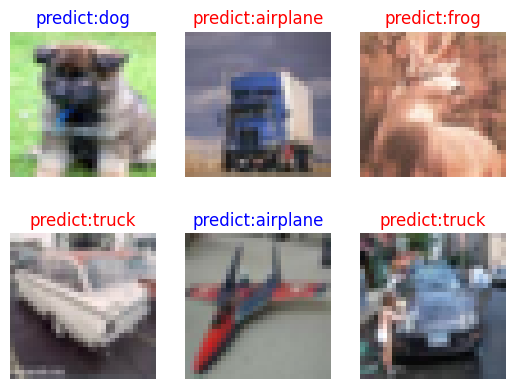

In [15]:
import mindspore as ms
# 定义VGG16网络，此处不采用预训练，即将pretrained设置为False
vgg16 = _vgg16(pretrained=False)

#param.requires_grad = True表示所有参数都需要求梯度进行更新。
for param in vgg16.get_parameters():
    param.requires_grad = True

# 设置训练的轮数和学习率，这里训练的轮数设置为10
num_epochs = 10
#基于余弦衰减函数计算学习率。学习率最小值为0.0001，最大值为0.0005，具体API见文档https://www.mindspore.cn/docs/zh-CN/master/api_python/nn/mindspore.nn.cosine_decay_lr.html?highlight=cosine_decay_lr
lr = nn.cosine_decay_lr(min_lr=0.0001, max_lr=0.0005, total_step=step_size_train * num_epochs,
                        step_per_epoch=step_size_train, decay_epoch=num_epochs)
# 定义优化器和损失函数
#Adam优化器，具体可参考论文https://arxiv.org/abs/1412.6980
opt = nn.Adam(params=vgg16.trainable_params(), learning_rate=lr)
# 交叉熵损失
loss_fn = nn.CrossEntropyLoss()

#前向传播，计算loss
def forward_fn(inputs, targets):
    logits = vgg16(inputs)
    loss = loss_fn(logits, targets)
    return loss

#计算梯度和loss
grad_fn = ops.value_and_grad(forward_fn, None, opt.parameters)

def train_step(inputs, targets):
    loss, grads = grad_fn(inputs, targets)
    opt(grads)
    return loss

# 实例化模型
model = ms.Model(vgg16, loss_fn, opt, metrics={"Accuracy": nn.Accuracy()})


# 创建迭代器
data_loader_train = dataset_train.create_tuple_iterator(num_epochs=num_epochs)
data_loader_val = dataset_val.create_tuple_iterator(num_epochs=num_epochs)

# 最佳模型存储路径
best_acc = 0
best_ckpt_dir = "./BestCheckpoint"
best_ckpt_path = "./BestCheckpoint/vgg16-best.ckpt"

import os
import stat

# 开始循环训练
print("Start Training Loop ...")

for epoch in range(num_epochs):
    losses = []
    vgg16.set_train()

    # 为每轮训练读入数据

    for i, (images, labels) in enumerate(data_loader_train):
        loss = train_step(images, labels)
        if i%100 == 0 or i == step_size_train -1:
            print('Epoch: [%3d/%3d], Steps: [%3d/%3d], Train Loss: [%5.3f]'%(
                epoch+1, num_epochs, i+1, step_size_train, loss))
        losses.append(loss)

    # 每个epoch结束后，验证准确率

    acc = model.eval(dataset_val)['Accuracy']

    print("-" * 50)
    print("Epoch: [%3d/%3d], Average Train Loss: [%5.3f], Accuracy: [%5.3f]" % (
        epoch+1, num_epochs, sum(losses)/len(losses), acc
    ))
    print("-" * 50)

    if acc > best_acc:
        best_acc = acc
        if not os.path.exists(best_ckpt_dir):
            os.mkdir(best_ckpt_dir)
        if os.path.exists(best_ckpt_path):
            os.chmod(best_ckpt_path, stat.S_IWRITE)#取消文件的只读属性，不然删不了
            os.remove(best_ckpt_path)
        ms.save_checkpoint(vgg16, best_ckpt_path)

print("=" * 80)
print(f"End of validation the best Accuracy is: {best_acc: 5.3f}, "
      f"save the best ckpt file in {best_ckpt_path}", flush=True)


"""
验证和评估效果并且将效果可视化
"""
import matplotlib.pyplot as plt

def visualize_model(best_ckpt_path, dataset_val):
    net = _vgg16(pretrained=False)
    # 加载模型参数
    param_dict = ms.load_checkpoint(best_ckpt_path)
    ms.load_param_into_net(net, param_dict)
    model = ms.Model(net)
    # 加载验证集的数据进行验证
    data = next(dataset_val.create_dict_iterator())
    images = data["image"].asnumpy()
    labels = data["label"].asnumpy()
    # 预测图像类别
    output = model.predict(ms.Tensor(data['image']))
    pred = np.argmax(output.asnumpy(), axis=1)

    # 图像分类
    classes = []

    with open(data_dir+"/batches.meta.txt", "r") as f:
        for line in f:
            line = line.rstrip()
            if line != '':
                classes.append(line)

    # 显示图像及图像的预测值
    plt.figure()
    for i in range(6):
        plt.subplot(2, 3, i+1)
        # 若预测正确，显示为蓝色；若预测错误，显示为红色
        color = 'blue' if pred[i] == labels[i] else 'red'
        plt.title('predict:{}'.format(classes[pred[i]]), color=color)
        picture_show = np.transpose(images[i], (1, 2, 0))
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.2023, 0.1994, 0.2010])
        picture_show = std * picture_show + mean
        picture_show = np.clip(picture_show, 0, 1)
        plt.imshow(picture_show)
        plt.axis('off')

    plt.show()

# 使用测试数据集进行验证
visualize_model(best_ckpt_path=best_ckpt_path, dataset_val=dataset_val)


## 另一次测试中，经过10个Epoch后准确率达到了55%，运行输出如下：

Start Training Loop ...

Epoch: [  1/ 10], Steps: [  1/8334], Train Loss: [2.304]
Epoch: [  1/ 10], Steps: [101/8334], Train Loss: [2.298]
……
Epoch: [  1/ 10], Steps: [8301/8334], Train Loss: [2.492]
Epoch: [  1/ 10], Steps: [8334/8334], Train Loss: [1.792]
--------------------------------------------------
Epoch: [  1/ 10], Average Train Loss: [2.073], Accuracy: [0.190]
--------------------------------------------------
Epoch: [  2/ 10], Steps: [  1/8334], Train Loss: [1.713]
……
Epoch: [  2/ 10], Steps: [8334/8334], Train Loss: [1.864]
--------------------------------------------------
Epoch: [  2/ 10], Average Train Loss: [1.907], Accuracy: [0.195]
--------------------------------------------------
Epoch: [  3/ 10], Steps: [  1/8334], Train Loss: [1.432]
……
Epoch: [  3/ 10], Steps: [8334/8334], Train Loss: [1.967]
--------------------------------------------------
Epoch: [  3/ 10], Average Train Loss: [1.834], Accuracy: [0.297]
--------------------------------------------------
Epoch: [  4/ 10], Steps: [  1/8334], Train Loss: [1.815]
……
Epoch: [  4/ 10], Steps: [8334/8334], Train Loss: [0.952]
--------------------------------------------------
Epoch: [  4/ 10], Average Train Loss: [1.680], Accuracy: [0.382]
--------------------------------------------------
Epoch: [  5/ 10], Steps: [  1/8334], Train Loss: [1.300]
……
Epoch: [  5/ 10], Steps: [8334/8334], Train Loss: [2.586]
--------------------------------------------------
Epoch: [  5/ 10], Average Train Loss: [1.557], Accuracy: [0.395]
--------------------------------------------------
Epoch: [  6/ 10], Steps: [  1/8334], Train Loss: [1.660]
……
Epoch: [  6/ 10], Steps: [8334/8334], Train Loss: [0.922]
--------------------------------------------------
Epoch: [  6/ 10], Average Train Loss: [1.460], Accuracy: [0.423]
--------------------------------------------------
Epoch: [  7/ 10], Steps: [  1/8334], Train Loss: [1.651]
……
Epoch: [  7/ 10], Steps: [8334/8334], Train Loss: [1.811]
 --------------------------------------------------
Epoch: [  7/ 10], Average Train Loss: [1.374], Accuracy: [0.514]
--------------------------------------------------
Epoch: [  8/ 10], Steps: [  1/8334], Train Loss: [0.895]
……
Epoch: [  8/ 10], Steps: [8334/8334], Train Loss: [1.344]
--------------------------------------------------
Epoch: [  8/ 10], Average Train Loss: [1.296], Accuracy: [0.514]
--------------------------------------------------
Epoch: [  9/ 10], Steps: [  1/8334], Train Loss: [1.672]
……
Epoch: [  9/ 10], Steps: [8334/8334], Train Loss: [0.477]
--------------------------------------------------
Epoch: [  9/ 10], Average Train Loss: [1.234], Accuracy: [0.512]
--------------------------------------------------
Epoch: [ 10/ 10], Steps: [  1/8334], Train Loss: [1.143]
……
Epoch: [ 10/ 10], Steps: [8334/8334], Train Loss: [4.882]
--------------------------------------------------
Epoch: [ 10/ 10], Average Train Loss: [1.192], Accuracy: [0.550]
--------------------------------------------------

================================================================================

End of validation the best Accuracy is:  0.550, save the best ckpt file in ./BestCheckpoint/resnet50-best.ckpt

可视化测试结果如下：
